In [1]:
#setup
import sys
import os
from math import log
import numpy as np
import pandas as pd
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten , BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D , AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

# Data Preprocessing and Basic EDA

In [2]:
# prepare the data

train_root_path = "./malimg_dataset/train"
val_root_path = "./malimg_dataset/validation"

from tensorflow.keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=train_root_path, target_size=(150,150), batch_size=10000)

Found 8404 images belonging to 25 classes.


In [3]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [4]:
imgs, labels = next(batches)
imgs.shape

(8404, 150, 150, 3)

In [5]:
labels.shape

(8404, 25)

In [6]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

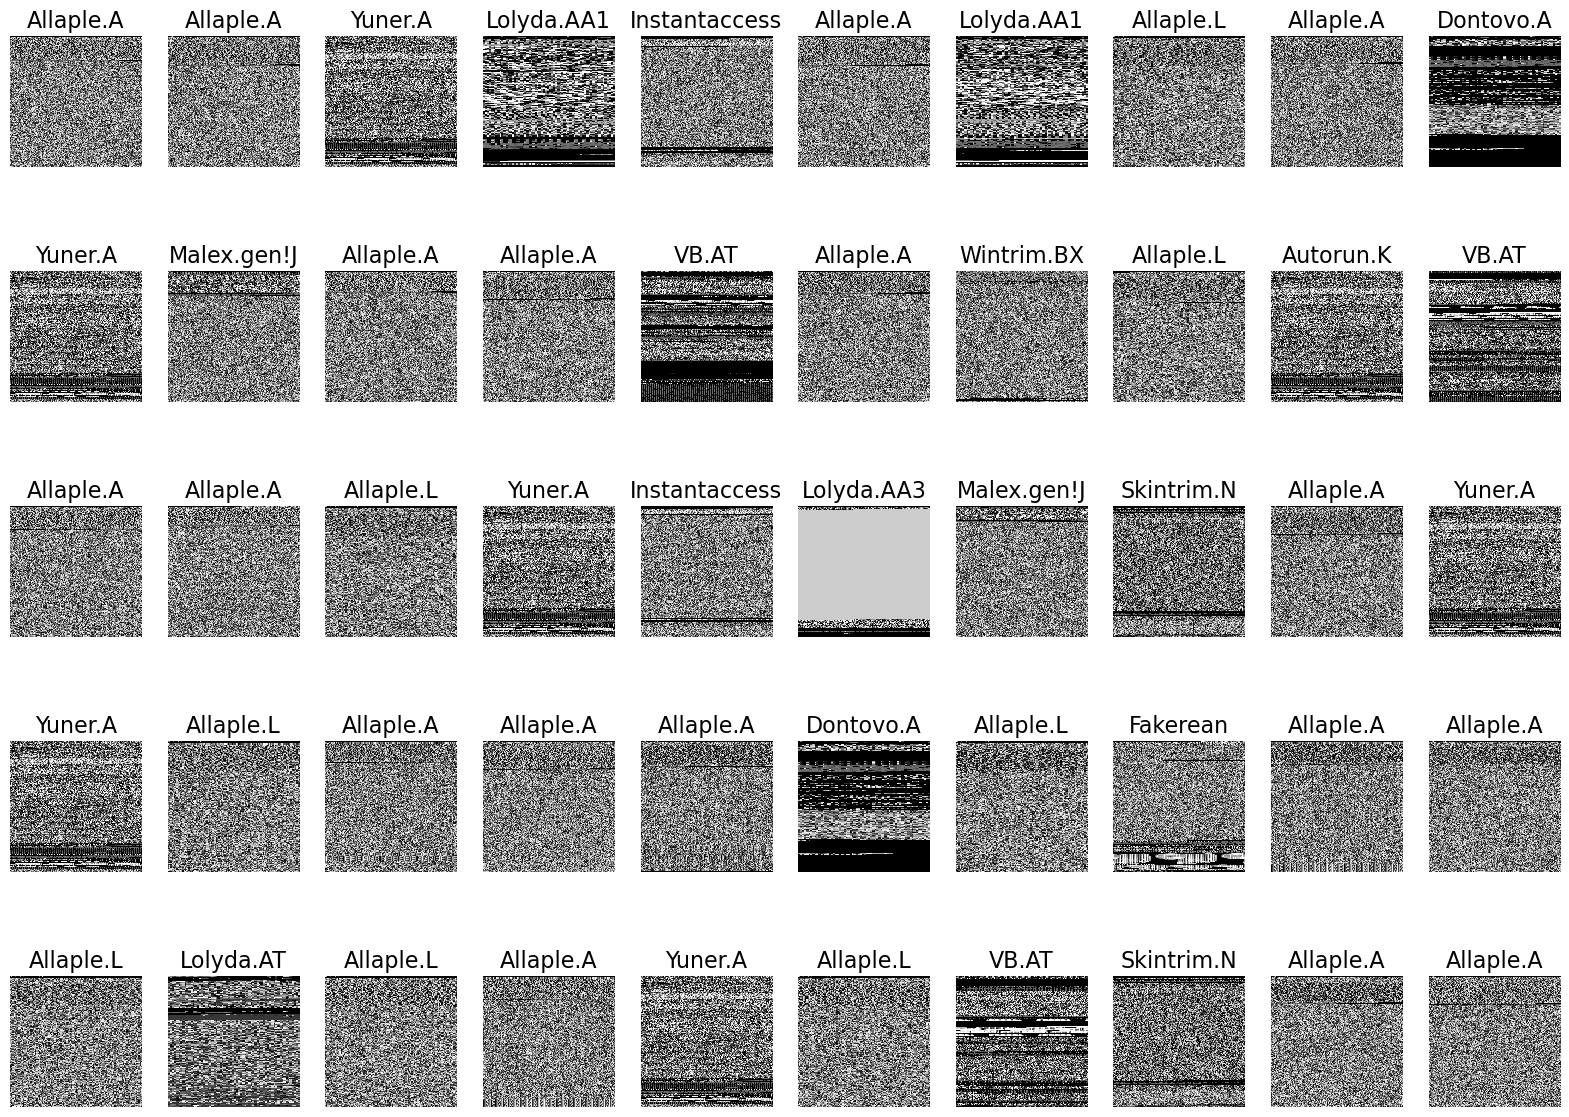

In [7]:
plots(imgs, titles = labels)

<BarContainer object of 25 artists>

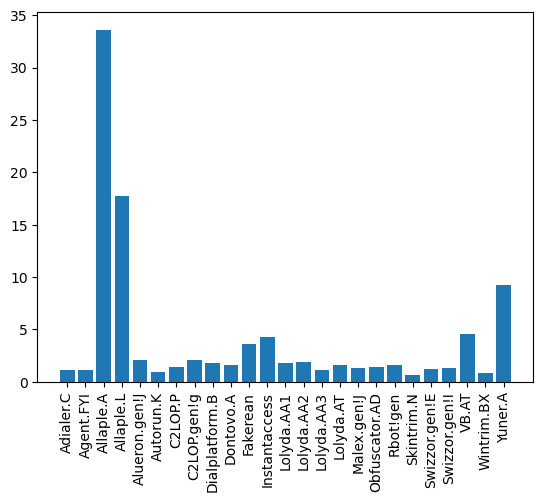

In [8]:
classes = batches.class_indices.keys()
perc = (sum(labels)/labels.shape[0])*100

plt.xticks(rotation='vertical')
plt.bar(classes,perc)

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [10]:
x_train.shape

(5882, 150, 150, 3)

In [11]:
y_test.shape

(2522, 25)

# Train CCN model

In [12]:
import tensorflow_addons as tfa

batch_size = 32 #128

learning_rate = 1e-3

num_epochs = 100
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

def malware_model(width , height):
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     #input_shape=(batch_size, width, height, 3)))
                    # https://stackoverflow.com/questions/47665391/keras-valueerror-input-0-is-incompatible-with-layer-conv2d-1-expected-ndim-4
                     input_shape=(width, height, 3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    
    Malware_model.add(Dense(25, activation='softmax'))
    # Malware_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer = 'adam', metrics=['accuracy'])

    Malware_model.compile(
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        optimizer=tfa.optimizers.AdamW(
            learning_rate=learning_rate, weight_decay=weight_decay
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    return Malware_model

In [13]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=4, verbose=1,  factor=0.4, min_lr=0.0001)

early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.00001, patience=8, mode='auto', restore_best_weights=True)

In [14]:

model=malware_model(150 , 150)
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
    verbose =1,
    callbacks=[early_stop,lr_reduction]
)

Epoch 1/100
166/166 [==============================] - 53s 314ms/step - loss: 1.6396 - accuracy: 0.6756 - top-5-accuracy: 0.8626 - val_loss: 0.9698 - val_accuracy: 0.8896 - val_top-5-accuracy: 0.9898 - lr: 0.0010
Epoch 2/100
166/166 [==============================] - 50s 304ms/step - loss: 1.0733 - accuracy: 0.8853 - top-5-accuracy: 0.9758 - val_loss: 0.8392 - val_accuracy: 0.9474 - val_top-5-accuracy: 0.9983 - lr: 0.0010
Epoch 3/100
166/166 [==============================] - 50s 299ms/step - loss: 0.9892 - accuracy: 0.9129 - top-5-accuracy: 0.9892 - val_loss: 0.8277 - val_accuracy: 0.9304 - val_top-5-accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
166/166 [==============================] - 54s 326ms/step - loss: 0.9402 - accuracy: 0.9350 - top-5-accuracy: 0.9921 - val_loss: 0.7905 - val_accuracy: 0.9559 - val_top-5-accuracy: 1.0000 - lr: 0.0010
Epoch 5/100
166/166 [==============================] - 51s 306ms/step - loss: 0.9045 - accuracy: 0.9426 - top-5-accuracy: 0.9960 - val_loss: 0.7769 

In [15]:
model.evaluate(x_test,  y_test)

79/79 [==============================] - 5s 59ms/step - loss: 0.7039 - accuracy: 0.9833 - top-5-accuracy: 0.9996


[0.7038777470588684, 0.9833465218544006, 0.9996035099029541]

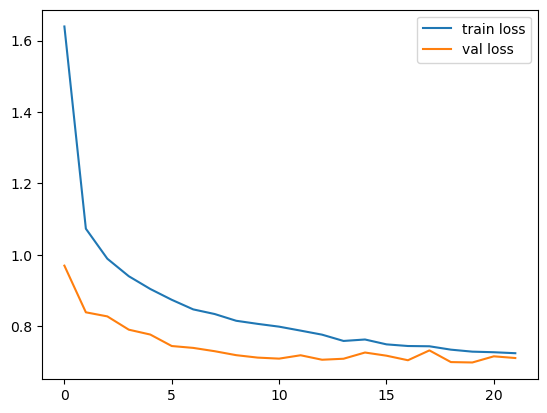

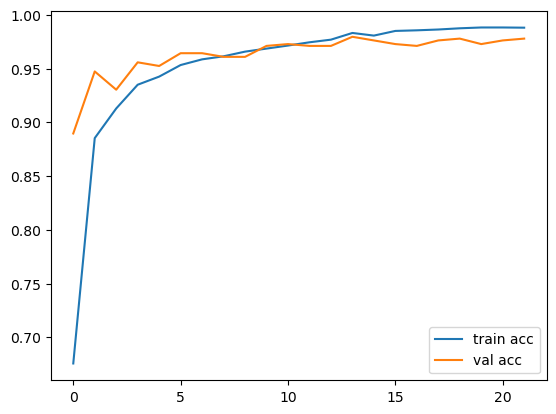

In [16]:
# plot the loss
plt.plot(model_fit.history['loss'], label='train loss')
plt.plot(model_fit.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss.jpg',format='jpg')

plt.close()
# plot the accuracy
plt.plot(model_fit.history['accuracy'], label='train acc')
plt.plot(model_fit.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc.jpg',format="jpg")

plt.close()

# Make predictions¶

In [17]:
pred_x = model.predict(x_test, verbose=0) 
y_pred=np.argmax(pred_x,axis=1)
y_pred

array([ 2,  9,  4, ...,  2, 24, 10], dtype=int64)

In [18]:
y_test2 = np.argmax(y_test, axis=1)
y_test2

array([ 2,  9,  4, ...,  2, 24, 10], dtype=int64)

In [19]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [20]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

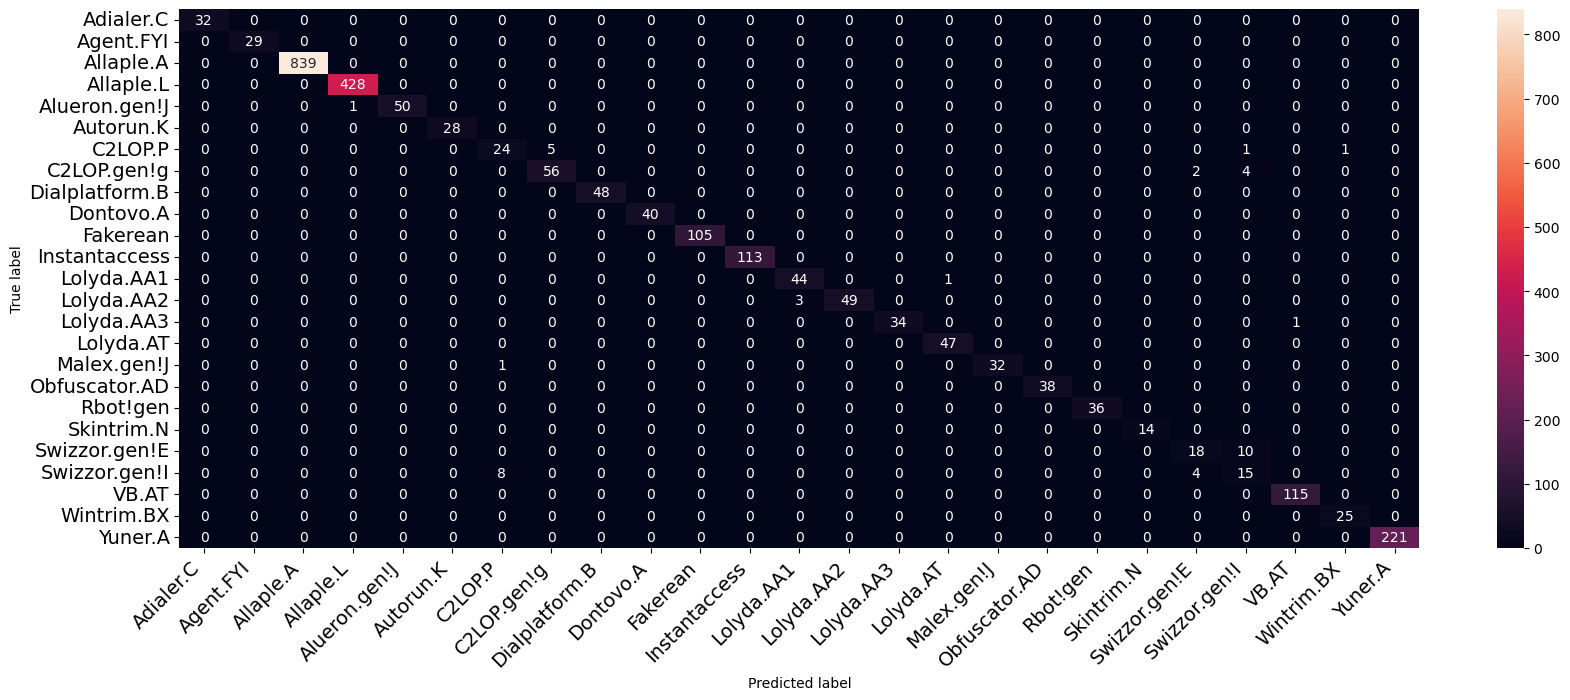

In [21]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

In [22]:
from sklearn import metrics
# Print the precision and recall, among other metrics
report =  metrics.classification_report(y_test2, y_pred, digits=3, output_dict=True)

df = pd.DataFrame(report).transpose().reset_index()
df = df.rename(columns={"index": "class_label"})

Let's review the part of the classification report related to each individual class

In [23]:
clf_rep = metrics.precision_recall_fscore_support(y_test2, y_pred)
out_dict = {
             "precision" : clf_rep[0].round(3)
            ,"recall" : clf_rep[1].round(3)
            ,"f1-score" : clf_rep[2].round(3)
            ,"support" : clf_rep[3]
            }
out_df = pd.DataFrame(out_dict).reset_index().rename(columns={"index": "class_label"})
class_label_values = dict(zip(range(0,len(batches.class_indices)), batches.class_indices))
out_df['class_label'] = out_df['class_label'].map(class_label_values)
out_df

,class_label,precision,recall,f1-score,support
0,Adialer.C,1.000,1.000,1.000,32
1,Agent.FYI,1.000,1.000,1.000,29
2,Allaple.A,1.000,1.000,1.000,839
3,Allaple.L,0.998,1.000,0.999,428
4,Alueron.gen!J,1.000,0.980,0.990,51
5,Autorun.K,1.000,1.000,1.000,28
6,C2LOP.P,0.727,0.774,0.750,31
7,C2LOP.gen!g,0.918,0.903,0.911,62
8,Dialplatform.B,1.000,1.000,1.000,48
9,Dontovo.A,1.000,1.000,1.000,40


In [24]:
# display aggregated values - selecting rows based on condition 
options = ['accuracy', 'macro avg',  'weighted avg']
agg_df = df[df['class_label'].isin(options)]
agg_df

,class_label,precision,recall,f1-score,support
25,accuracy,0.983347,0.983347,0.983347,0.983347
26,macro avg,0.950449,0.948697,0.949224,2522.000000
27,weighted avg,0.983807,0.983347,0.983464,2522.000000
